In [8]:
import json
import urllib
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
texas = pd.read_csv('statement_data.csv')

In [10]:
texas.head()

,execution,offender_information,last_statement,last_name,first_name,tdcj_number,age,date,race,county,statement_text
0,538,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Fuller,Barney,999481,58,10/05/2016,White,Houston,"I don't have anything to say, you can proceed ..."
1,537,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Vasquez,Pablo,999297,38,04/06/2016,Hispanic,Hidalgo,"I just want to tell my family thank you, my mo..."
2,536,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Ward,Adam,999525,33,03/22/2016,White,Hunt,I would like to thank everyone that has showed...
3,535,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Wesbrook,Coy,999281,58,03/09/2016,White,Harris,"Yeah, first off, I want to say that I am sorry..."
4,534,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Garcia,Gustavo,999018,43,02/16/2016,Hispanic,Collin,"To my family, to my mom, I love you. God bless..."


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from altair import Chart, X, Y, Axis, Scale, Color, Bin, SortField, Column, Formula

# Two convenience functions to work with Altair and Matplotlib
def show(*charts, width=700, height=300):
    for chart in charts:
        chart.configure_cell(width=width, height=height).display()
        
def pie(ax, *args, **kwargs):
    patches, _, _ = ax.pie(
        *args,
        colors=['#BEE9E8', '#62B6CB', '#5FA8D3', '#DCEDEC'],
        autopct='%1.1f%%',
        **kwargs
    )
    for p in patches:
        p.set_linewidth(0.6)
    ax.axis('equal')

In [29]:
import scrapy

class TexasDeathSpider(scrapy.Spider):
    name = 'texas_death'
    allowed_domains = ['www.tdcj.state.tx.us']
    start_urls = (
        'http://www.tdcj.state.tx.us/death_row/dr_executed_offenders.html',
    )

    def parse(self, response):
        _, *rows = response.css('table tr')
        fields = ['execution', 'last_name', 'first_name', 'tdcj_number',
                  'age_execution', 'date_execution', 'race', 'county']
        for row in rows:
            item = PersonItem()
            values = row.css('td::text').extract()
            if len(values) > len(fields):
                # Special cases: people #416 and #419
                del values[1]
            for field, value in zip(fields, values):
                item[field] = value.strip()

            info, last_stmt = row.css('td > a::attr(href)').extract()
            no_info = info.endswith(('.jpg', 'no_info_available.html'))
            no_stmt = last_stmt.endswith('no_last_statement.html')
            if no_info:
                item['gender'] = ''
                info = False
            if no_stmt:
                item['last_statement'] = ''

            if no_info and no_stmt:
                yield item
            elif no_stmt:
                yield scrapy.Request(response.urljoin(info),
                                     callback=self.parse_gender,
                                     meta={'item': item})
            else:
                info_url = response.urljoin(info) if info else False
                yield scrapy.Request(response.urljoin(last_stmt),
                                     callback=self.parse_last_stmt,
                                     meta={'item': item,
                                           'info_url': info_url})

    def parse_last_stmt(self, response):
        item = response.meta['item']
        info_url = response.meta['info_url']
        ps = [p.strip() for p in response.css('p::text').extract()
              if p.strip()]
        item['last_statement'] = ps[-1]
        if not info_url:
            yield item
            return
        yield scrapy.Request(
                info_url,
                callback=self.parse_gender,
                meta={'item': item},
        )

    def parse_gender(self, response):
        item = response.meta['item']
        rows = response.css('table tr')
        item['gender'] = rows[10].css('td::text').extract()[-1].strip()
        yield item
        
        
# dataset = tablib.Dataset()
# dataset.headers = ["reference_link", "rss_link"]

# def add_item(item):    
#    dataset.append([item.get(field) for fields in dataset.headers])

# for item in items:
#     add_item(item)

# f.write(texas_death_items.csv)  


#scrapy crawl <TexasDeathSpider> -o texas_death_items.csv -t csv
        


In [18]:
people = pd.read_csv('statement_data.csv')

In [19]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 11 columns):
execution               538 non-null int64
offender_information    538 non-null object
last_statement          538 non-null object
last_name               538 non-null object
first_name              538 non-null object
tdcj_number             538 non-null int64
age                     538 non-null int64
date                    538 non-null object
race                    538 non-null object
county                  538 non-null object
statement_text          538 non-null object
dtypes: int64(3), object(8)
memory usage: 46.3+ KB


In [20]:
people.head()

,execution,offender_information,last_statement,last_name,first_name,tdcj_number,age,date,race,county,statement_text
0,538,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Fuller,Barney,999481,58,10/05/2016,White,Houston,"I don't have anything to say, you can proceed ..."
1,537,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Vasquez,Pablo,999297,38,04/06/2016,Hispanic,Hidalgo,"I just want to tell my family thank you, my mo..."
2,536,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Ward,Adam,999525,33,03/22/2016,White,Hunt,I would like to thank everyone that has showed...
3,535,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Wesbrook,Coy,999281,58,03/09/2016,White,Harris,"Yeah, first off, I want to say that I am sorry..."
4,534,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Garcia,Gustavo,999018,43,02/16/2016,Hispanic,Collin,"To my family, to my mom, I love you. God bless..."


In [30]:
people.date.map(len).value_counts()

10    536
9       2
Name: date, dtype: int64

In [31]:
people.date[people.date.map(len) == 9]

9      10/6/2015
118    11/6/2008
Name: date, dtype: object

In [32]:
import datetime

def _read_date(date):
    return datetime.datetime.strptime(date, '%m/%d/%Y')

people.date = people.date.map(_read_date)

In [34]:
race_counts = people['race'].value_counts().reset_index()
race_counts.columns = ['race', 'count']
pop = pd.DataFrame({'race': ['White', 'Black', 'Hispanic', 'Other'], 'count': [196817552, 37685848, 50477594, 23764544]})

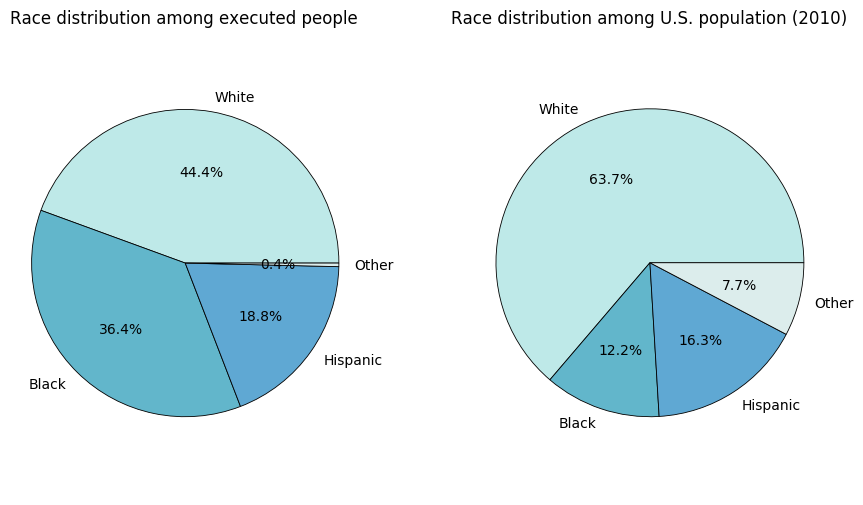

In [47]:
#Change to different visualization--- not pie chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))
pie(ax1, race_counts['count'], labels=race_counts['race'])
pie(ax2, pop['count'], labels=pop['race'])
ax1.set_title('Race distribution among executed people')
ax2.set_title('Race distribution among U.S. population (2010)')
fig.subplots_adjust(wspace=0.5)
plt.show(fig)


In [48]:
# show(Chart(people[['race', 'count']]).mark_bar().encode(
#         column=Column('race',
#                       bin=Bin(maxbins=10)),
#         x=X('race',
#             axis=Axis(labels=False, tickSize=0, titleFontSize=0),
#             scale=Scale(bandSize=8)),
#         y='count(*)',
#         color='race',
#     ).configure_facet_cell(strokeWidth=0))



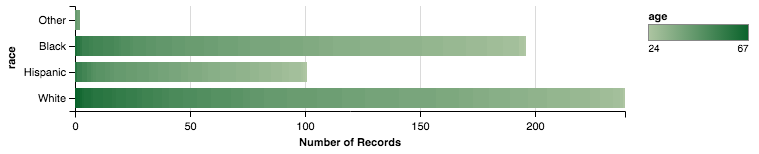

In [50]:
show(Chart(people[['race', 'age']].dropna()).mark_bar().encode(
        x='count(*)',
        y=Y('race',
            sort=SortField('count(*)', op='mean', order='descending')),
        color='age',
    ), width=550)

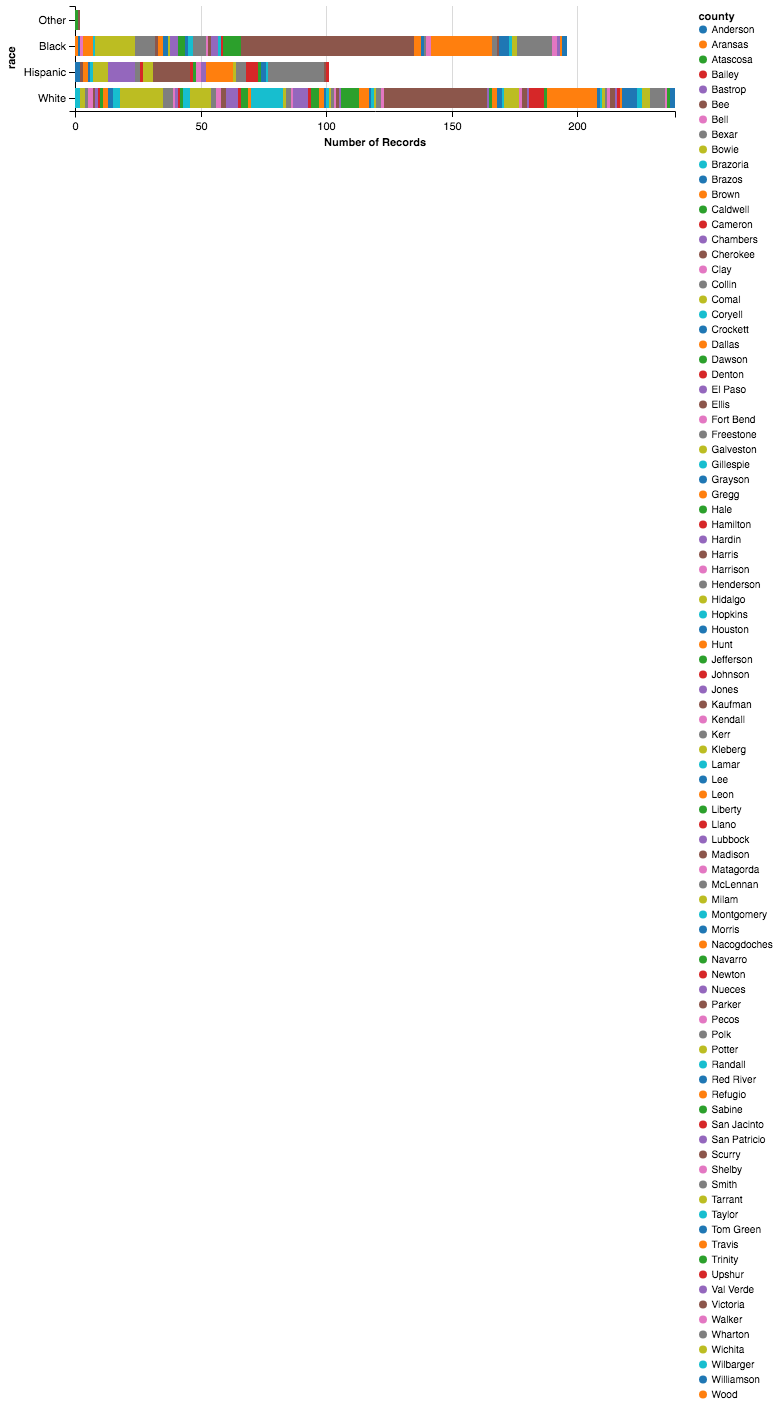

In [51]:
show(Chart(people[['race', 'county']].dropna()).mark_bar().encode(
        x='count(*)',
        y=Y('race',
            sort=SortField('count(*)', op='mean', order='descending')),
        color='county',
    ), width=600)

In [52]:
people.columns


Index(['execution', 'offender_information', 'last_statement', 'last_name',
       'first_name', 'tdcj_number', 'age', 'date', 'race', 'county',
       'statement_text'],
      dtype='object')

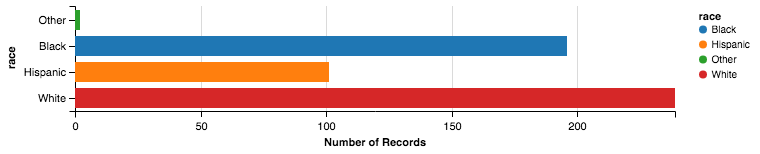

In [55]:
show(Chart(people[['race', 'age']].dropna()).mark_bar().encode(
        x='count(*)',
        y=Y('race',
            sort=SortField('count(*)', op='mean', order='descending')),
        color='race',
    ), width=600)